In [1]:
# Created by: Chen Da
# Created on: 20191217

In [6]:
import pandas as pd
import numpy as np
import random, warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

In [3]:
def final_model(df):
    predict_score = list()
    for info in range(df.shape[0]):
        new_data = df.iloc[info, :].values[1:-1]
        z = np.dot(new_data, coefs) + intercept
        y = 1 / (1 + np.exp(-z))
        predict_score.append(y)
    predict_df = pd.DataFrame(predict_score, columns=['pro'])
    df.index = [i for i in range(df.shape[0])]
    predict_df['id'] = df['id']
    predict_df['class'] = df['class']
    predict_df = predict_df.reindex(columns=['id', 'pro', 'class'])
    positive = predict_df[predict_df['class'] == 1]
    negtive = predict_df[predict_df['class'] == 0]
    plt.figure(figsize=(20, 12))
    plt.scatter(x=positive['id'], y=positive['pro'], color='red')
    plt.scatter(x=negtive['id'], y=negtive['pro'], color='blue')
    plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()
    predict_df['pre_label'] = predict_df['pro'].apply(lambda x: round(x))
    predict_df['class'] = predict_df['class'].apply(lambda x: int(x))
    pre_0_right = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 0)].shape[0]
    pre_0_wrong = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 1)].shape[0]
    pre_1_right = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 1)].shape[0]
    pre_1_wrong = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 0)].shape[0]
    print('总体准确率为%s' % ((pre_0_right + pre_1_right) / predict_df.shape[0]))
    return predict_df

In [4]:
def split_func(data_frame, size=0.8):
    """
    Split the data into two data set
    :param data_frame: the name of input data
    :param size : the size of train data
    :return: train_data, test_data
    """
    data_frame = pd.DataFrame(data_frame.values,
                              index=[i for i in range(data_frame.values.shape[0])],
                              columns=data_frame.columns)
    healthy_data = data_frame[data_frame["class"] == 0]
    unhealthy_data = data_frame[data_frame["class"] == 1]
    healthy_index = list(healthy_data.index)
    unhealthy_index = list(unhealthy_data.index)
    healthy_train_data_index = random.sample(healthy_index, int(size * len(healthy_index)))
    unhealthy_train_data_index = random.sample(unhealthy_index, int(size * len(unhealthy_index)))
    healthy_test_data_index = list(set(healthy_index).difference(set(healthy_train_data_index)))
    unhealthy_test_data_index = list(set(unhealthy_index).difference(set(unhealthy_train_data_index)))
    train_index = list(set(healthy_train_data_index).union(set(unhealthy_train_data_index)))
    test_index = list(set(healthy_test_data_index).union(set(unhealthy_test_data_index)))
    train = data_frame.iloc[train_index, :]
    test = data_frame.iloc[test_index, :]
    return train, test

In [10]:
path = 'C:/Users/pc/OneDrive/PLTTECH/Project/20191217_colorectal_cancer/'
df_name = 'rawdata'
df = pd.read_excel(path + 'rawdata/' + df_name + '.xlsx')
df['id'] = df['id'].apply(lambda x:str(x))
pnasSubsetsIndex = [0, 4, 5, 29, 43, 58, 60, 70, 71, 81, 91, 95, 96, 98, 99, 101, 62, 64, 76, 77, 89, 90, 103]       
df = df.iloc[:, pnasSubsetsIndex]
df.iloc[:, 1:-1] = df.iloc[:, 1:-1].multiply(100)
stdsc = StandardScaler()
df.iloc[:, 1:-1] = pd.DataFrame(stdsc.fit_transform(df.iloc[:, 1:-1].values), columns=df.columns[1:-1])
df.shape

(40, 23)

In [12]:
## 划分训练集和测试集
train_df, test_df = split_func(df)
X_train = train_df.iloc[:, 1:-1].values
y_train = train_df['class'].values.astype('int')
X_test = test_df.iloc[:, 1:-1].values
y_test = test_df['class'].values.astype('int')
# X_train = df.iloc[:, 1:-1].values
# y_train = df['class'].values.astype('int')

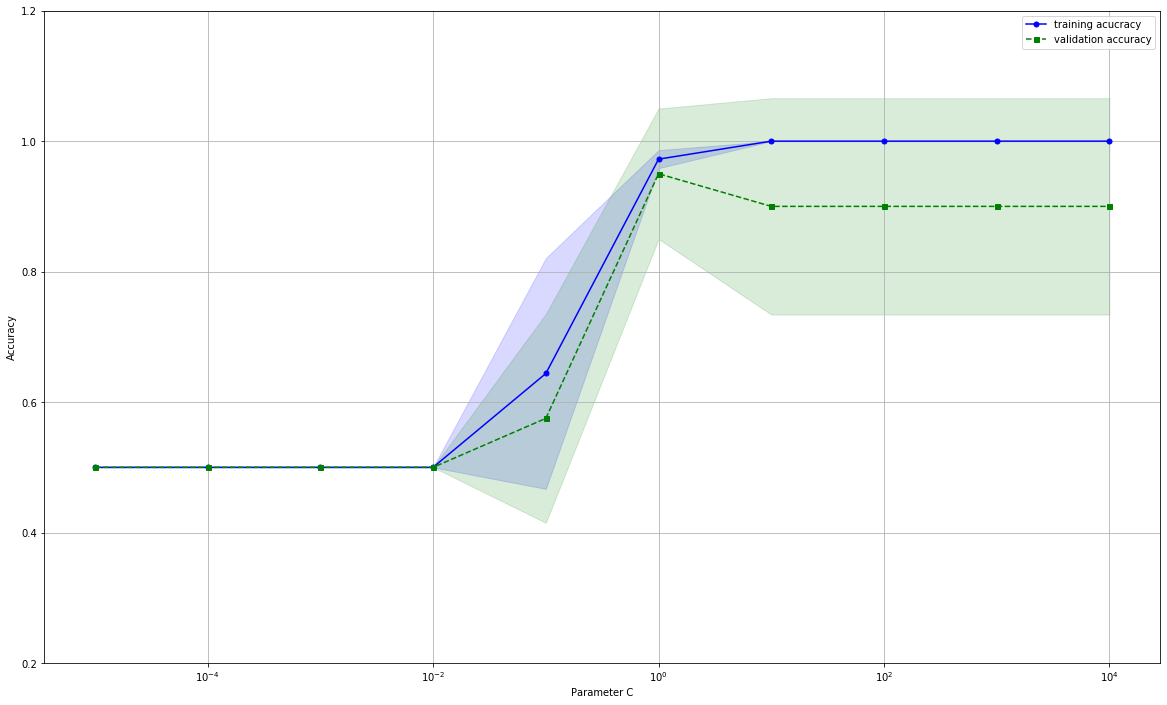

In [13]:
# 通过验证曲线来确定正则参数
# clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2)
clf = LogisticRegression(penalty='l1')
# param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_range = [10**i for i in range(-5, 5)]
train_scores, test_scores = validation_curve(estimator=clf, X=X_train, 
                                             y=y_train,
                                             param_name='C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(20,12))
plt.plot(param_range, train_mean, color='blue', marker='o',
         markersize=5, label='training acucracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std,
                 alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.show()  

In [35]:
lr = LogisticRegression(penalty='l1', C=10)
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
# help(LogisticRegression)

In [37]:
lr.score(X_train, y_train)

1.0

In [38]:
lr.score(X_test, y_test)

0.875

In [39]:
coefs = list(lr.coef_[0])
intercept = lr.intercept_[0]
select_subsets_id = [list(lr.coef_[0]).index(i) for i in list(lr.coef_[0]) if i != 0]
select_subsets = [list(df.columns[1:-1])[i] for i in select_subsets_id]
print(len(select_subsets))
select_subsets.append('class')
select_subsets.insert(0, 'id')
print(select_subsets)
coefs = [i for i in coefs if i != 0]
print(coefs)
print(intercept)

12
['id', 'Lymphocytes/CD3+', 'Lymphocytes/CD3+/CD4+', 'Lymphocytes/CD3+/CD4+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3+/CD8+/HLA-DR+', 'Lymphocytes/CD3+/CD8+/PD1+', 'Lymphocytes/CD3-', 'Myeloid cells/CD56-CD14-/DC cells/mDC', 'Myeloid cells/HLA-DR-/MDSC', 'Lymphocytes/CD3+/CD8+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3-/B cells/Q2: 145Nd_IgD+ , 153Eu_CD27+', 'Lymphocytes/CD3-/B cells/Q3: 145Nd_IgD+ , 153Eu_CD27-', 'Lymphocytes/NKT', 'class']
[0.9074448021743782, 1.0390403595457338, -0.05740507577089001, 2.3332424335378428, 2.559187344993976, -0.40911363602478157, 0.8121301312191118, 2.620548182357151, 0.49525274872248637, -0.37292687375891687, -1.4375030761917278, -0.26236577541542033]
0.728162928081308


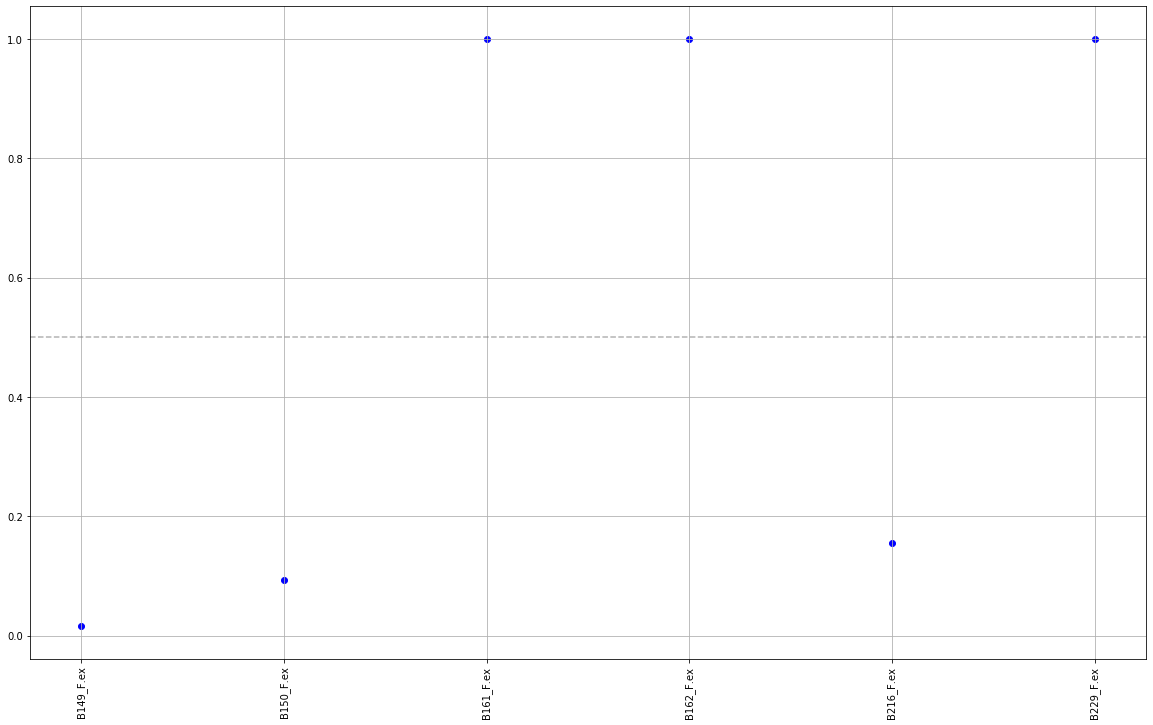

总体准确率为0.5


In [46]:
PLT_healthy_new = pd.read_excel('C:/Users/pc/OneDrive/PLTTECH/Project/00_immune_age_project/Task/20191223/健康人6例/real_all.xlsx')
PLT_healthy_new = PLT_healthy_new.iloc[:, pnasSubsetsIndex]
PLT_healthy_new.iloc[:, 1:-1] = PLT_healthy_new.iloc[:, 1:-1].multiply(100)
PLT_healthy_new.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(PLT_healthy_new.iloc[:, 1:-1].values), columns=PLT_healthy_new.columns[1:-1])
PLT_healthy_new = PLT_healthy_new.loc[:, select_subsets]
pre_PLT_healthy_new = final_model(PLT_healthy_new)

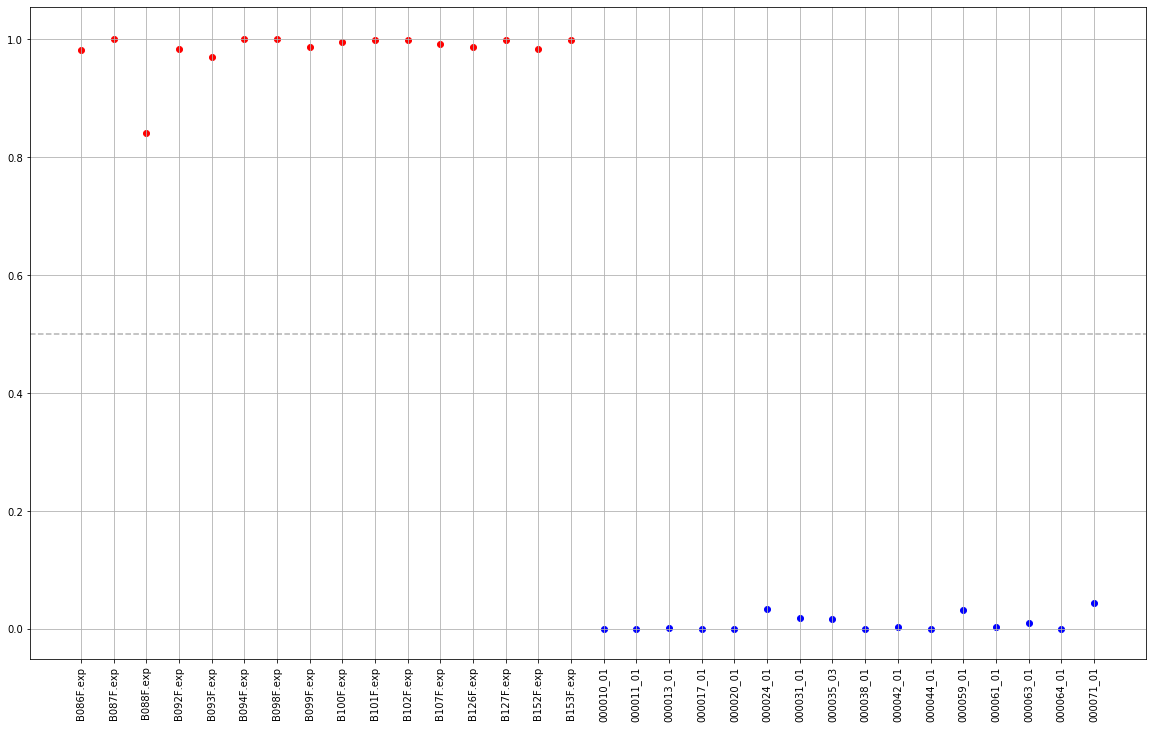

总体准确率为1.0


In [41]:
# pre_train = final_model(train_df.loc[:, select_subsets])

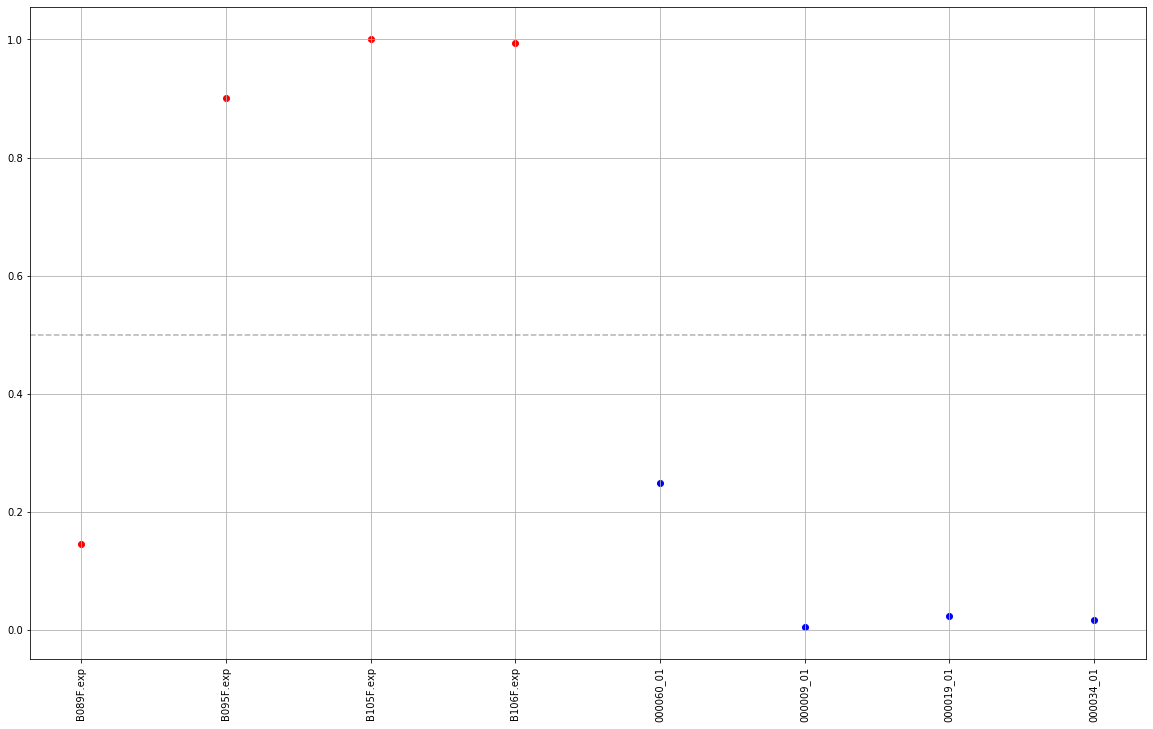

总体准确率为0.875


In [42]:
# pre_test = final_model(test_df.loc[:, select_subsets])

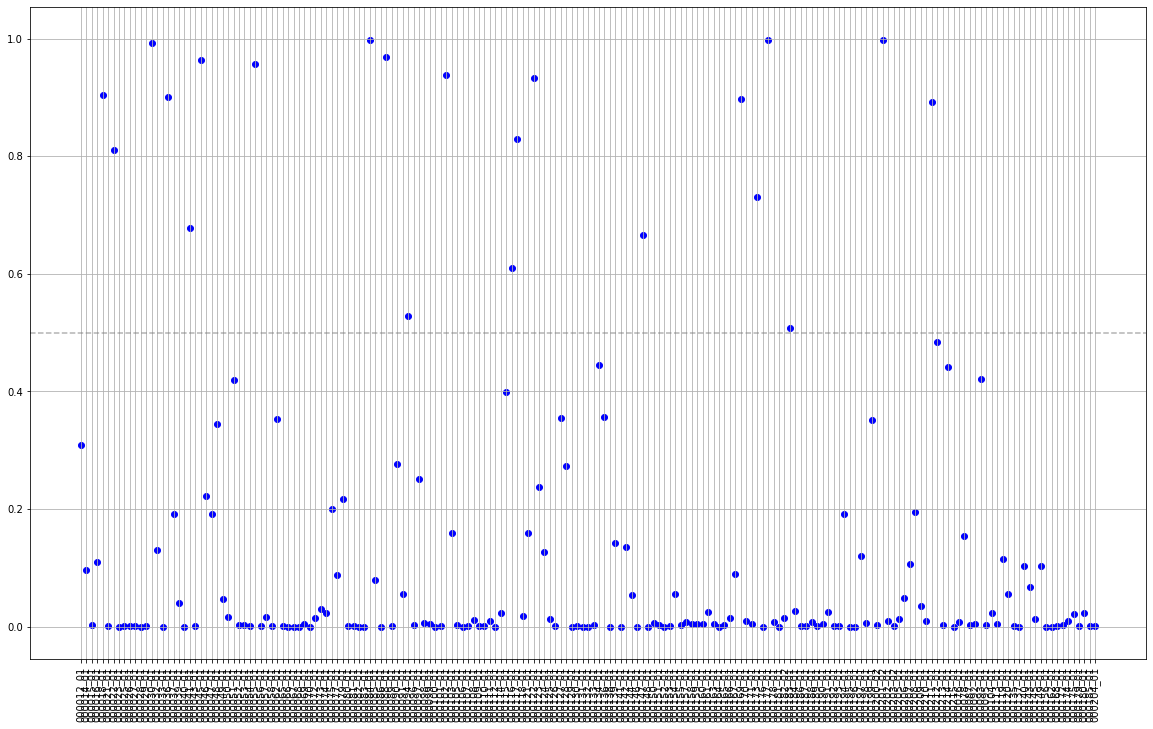

总体准确率为0.8877005347593583


In [43]:
# healthy_new = pd.read_excel(path + 'rawdata/test_healthy_new.xlsx')
# healthy_new = healthy_new.iloc[:, pnasSubsetsIndex]
# healthy_new.iloc[:, 1:-1] = healthy_new.iloc[:, 1:-1].multiply(100)
# healthy_new.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(healthy_new.iloc[:, 1:-1].values), columns=healthy_new.columns[1:-1])
# healthy_new = healthy_new.loc[:, select_subsets]
# pre_healthy_new = final_model(healthy_new)

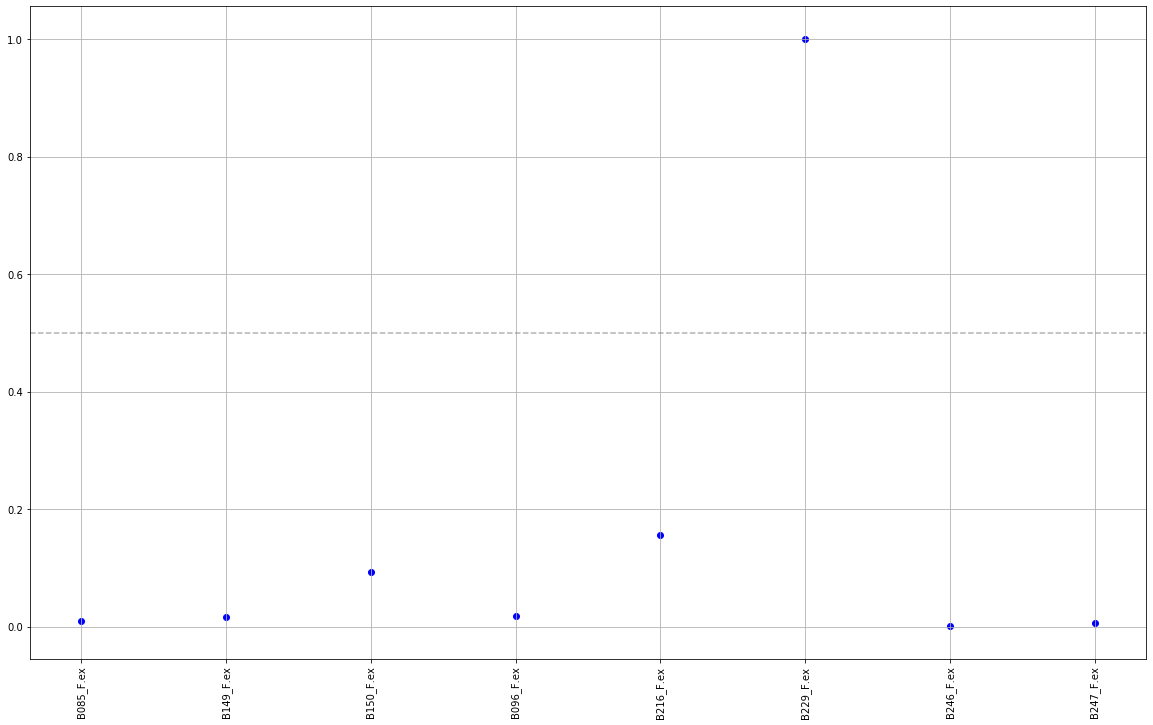

总体准确率为0.875


In [44]:
# PLT_healthy_new = pd.read_excel(path + 'rawdata/test_PLT_healthy.xlsx')
# PLT_healthy_new = PLT_healthy_new.iloc[:, pnasSubsetsIndex]
# PLT_healthy_new.iloc[:, 1:-1] = PLT_healthy_new.iloc[:, 1:-1].multiply(100)
# PLT_healthy_new.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(PLT_healthy_new.iloc[:, 1:-1].values), columns=PLT_healthy_new.columns[1:-1])
# PLT_healthy_new = PLT_healthy_new.loc[:, select_subsets]
# pre_PLT_healthy_new = final_model(PLT_healthy_new)